# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. Заказчиком предоставлены исторические данные: технические характеристики, комплектации и цены автомобилей.

Цели и задачи проекта:  нам нужно построить модель для определения стоимости автомобиля с учетом того, что заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

<br>1. Проведем EDA.Подготовим выборки для обучения моделей.
<br>1. Обучим разные модели, одна из которых — LightGBM, как минимум одна — не бустинг. Для каждой модели попробуем разные гиперпараметры.
<br>3. Проанализируем время обучения, время предсказания и качество моделей.
<br>4. Опираясь на критерии заказчика, выберем лучшую модель, проверем её качество на тестовой выборке.

## Подготовка данных

Импортируем необходимые библиотеки.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import lightgbm as lgb
from pandas import get_dummies
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor

Отроем файл с данными.

In [2]:
df = pd.read_csv('/datasets/autos.csv')

In [3]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Посмотрим на признаки. Их форматы, названия, отсутствие данных и проч. 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

Строковыми object у нас являются: **DateCrawled** — дата скачивания анкеты из базы, **VehicleType** — тип автомобильного кузова,**Gearbox** — тип коробки передач, **Model** — модель автомобиля, **FuelType** — тип топлива, **Brand** — марка автомобиля, **NotRepaired** — была машина в ремонте или нет, **DateCreated** — дата создания анкеты, **LastSeen** — дата последней активности пользователя.
<br> 1. Все даты строковые. Нужно это исправить.
<br> 2. В названиях столбцов есть заглавные буквы. Сведем все к нижнему регистру.
<br> 3. В данных есть нули.

### Изменение типов данных

Названия признаков с датами запишем в отдельный список. <br>Посмотрим на формат записи даты для перевода строки методом to_datetime(). 

In [5]:
dates = ['DateCrawled','DateCreated','LastSeen']
df[dates]

,DateCrawled,DateCreated,LastSeen
0,2016-03-24 11:52:17,2016-03-24 00:00:00,2016-04-07 03:16:57
1,2016-03-24 10:58:45,2016-03-24 00:00:00,2016-04-07 01:46:50
2,2016-03-14 12:52:21,2016-03-14 00:00:00,2016-04-05 12:47:46
3,2016-03-17 16:54:04,2016-03-17 00:00:00,2016-03-17 17:40:17
4,2016-03-31 17:25:20,2016-03-31 00:00:00,2016-04-06 10:17:21
...,...,...,...
354364,2016-03-21 09:50:58,2016-03-21 00:00:00,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2016-03-14 00:00:00,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,2016-03-05 00:00:00,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,2016-03-19 00:00:00,2016-04-07 07:15:26


Меняем формат. Проверяем изменения.

In [6]:
for date in dates:
    df[date] = pd.to_datetime(df[date], format = '%Y-%m-%d %H:%M:%S')
df.info()      

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        354369 non-null  datetime64[ns]
 1   Price              354369 non-null  int64         
 2   VehicleType        316879 non-null  object        
 3   RegistrationYear   354369 non-null  int64         
 4   Gearbox            334536 non-null  object        
 5   Power              354369 non-null  int64         
 6   Model              334664 non-null  object        
 7   Kilometer          354369 non-null  int64         
 8   RegistrationMonth  354369 non-null  int64         
 9   FuelType           321474 non-null  object        
 10  Brand              354369 non-null  object        
 11  NotRepaired        283215 non-null  object        
 12  DateCreated        354369 non-null  datetime64[ns]
 13  NumberOfPictures   354369 non-null  int64   

### Корректировка названий столбцов.

Займемся регистром в названиях признаков. Проверяем результат.

In [7]:
df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]
df.columns 

/tmp/ipykernel_238/3420232386.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  df.columns = df.columns.str.replace(r"([A-Z])", r" \1").str.lower().str.replace(' ', '_').str[1:]


Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### Проверка пропусков в данных.

In [8]:
df.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
not_repaired          71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

У нас достаточно пропусков. Пропуски есть в признаках vehicletype - тип кузова, gearbox - тип коробки, model - модель авто, fueltype - тип топлива и notrepaired - была машина в ремонте или нет. Пока осталяем как есть.В дальнейшем вернумся к данной проблеме.

### Проверка на дубликаты.

Проверим данные на дубли.

In [9]:
df.duplicated().sum()

4

Дубли есть. Посмотрим, что это за сроки.

In [10]:
df[df.duplicated()]

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
171088,2016-03-08 18:42:48,1799,coupe,1999,auto,193,clk,20000,7,petrol,mercedes_benz,no,2016-03-08,0,89518,2016-03-09 09:46:57
231258,2016-03-28 00:56:10,1000,small,2002,manual,83,other,150000,1,petrol,suzuki,no,2016-03-28,0,66589,2016-03-28 08:46:21
258109,2016-04-03 09:01:15,4699,coupe,2003,auto,218,clk,125000,6,petrol,mercedes_benz,yes,2016-04-03,0,75196,2016-04-07 09:44:54
325651,2016-03-18 18:46:15,1999,wagon,2001,manual,131,passat,150000,7,gasoline,volkswagen,no,2016-03-18,0,36391,2016-03-18 18:46:15


Объявления не задубленые, видимо, так решил из-за numberofpictures. В этих объявлениях нет фото.

In [11]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

In [12]:
cat = ['vehicle_type','gearbox','model','fuel_type','brand','not_repaired']
for cat_ in cat:
    print(cat_)
    print(np.sort(df[cat_].value_counts().index))
    print()

vehicle_type
['bus' 'convertible' 'coupe' 'other' 'sedan' 'small' 'suv' 'wagon']

gearbox
['auto' 'manual']

model
['100' '145' '147' '156' '159' '1_reihe' '1er' '200' '2_reihe' '300c'
 '3_reihe' '3er' '4_reihe' '500' '5_reihe' '5er' '601' '6_reihe' '6er'
 '7er' '80' '850' '90' '900' '9000' '911' 'a1' 'a2' 'a3' 'a4' 'a5' 'a6'
 'a8' 'a_klasse' 'accord' 'agila' 'alhambra' 'almera' 'altea' 'amarok'
 'antara' 'arosa' 'astra' 'auris' 'avensis' 'aveo' 'aygo' 'b_klasse'
 'b_max' 'beetle' 'berlingo' 'bora' 'boxster' 'bravo' 'c1' 'c2' 'c3' 'c4'
 'c5' 'c_klasse' 'c_max' 'c_reihe' 'caddy' 'calibra' 'captiva' 'carisma'
 'carnival' 'cayenne' 'cc' 'ceed' 'charade' 'cherokee' 'citigo' 'civic'
 'cl' 'clio' 'clk' 'clubman' 'colt' 'combo' 'cooper' 'cordoba' 'corolla'
 'corsa' 'cr_reihe' 'croma' 'crossfire' 'cuore' 'cx_reihe' 'defender'
 'delta' 'discovery' 'doblo' 'ducato' 'duster' 'e_klasse' 'elefantino'
 'eos' 'escort' 'espace' 'exeo' 'fabia' 'fiesta' 'focus' 'forester'
 'forfour' 'fortwo' 'fox' 'free

Начнем с признака model. Название range_rover написано: range_rover и  rangerover. Посчитаем сколько у нас таких значений.

In [13]:
len(df.loc[(df['model']=='range_rover') | (df['model']=='rangerover')])

81

Проведем замену.

In [14]:
df.loc[(df.model=='range_rover'), 'model'] ='rangerover'

Посчитаем сколько объектов с уазанием range_rover.

In [15]:
len(df.loc[df['model']=='range_rover'])

0

Посчитаем сколько объектов с уазанием rangerover.

In [16]:
len(df.loc[df['model']=='rangerover'])

81

Все сошлось. <br>Перейдем к топливу. У нас есть gasoline и petrol. Это бензин. Объединим все под названием petrol. Посчитаем сколько у нас таких значений. 

In [17]:
len(df.loc[(df['fuel_type']=='gasoline') | (df['fuel_type']=='petrol')])

315072

Проведем замену.

In [18]:
df.loc[(df.fuel_type=='gasoline'), 'fuel_type'] ='petrol'

Посчитаем сколько объектов с уазанием gasoline.

In [19]:
len(df.loc[df['fuel_type']=='gasoline'])

0

Посчитаем сколько объектов с уазанием petrol.

In [20]:
len(df.loc[df['fuel_type']=='petrol'])

315072

Все сошлось. В остальном, все в порядке.

### Аномалии в данных

Для начала, посмотрим на данные методом describe().

In [21]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В данных нет отрицательных значений, т.к. мин значения - 0. Уже хорошо. <br>Миним значение даты регистрации 1000 год, а максимаьное 9999. Это вряд ли.<br> По признаку numberofpictures везде 0. Фото нет в объявлениях.<br> Также маловероятна мощность в 20000.

In [22]:
df.query('registration_year<1950 or registration_year>2022')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
15,2016-03-11 21:39:15,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,2016-03-11,0,24148,2016-03-19 08:46:47
622,2016-03-16 16:55:09,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,2016-03-16,0,44628,2016-03-20 16:44:37
1928,2016-03-25 15:58:21,7000,suv,1945,manual,48,other,150000,2,petrol,volkswagen,no,2016-03-25,0,58135,2016-03-25 15:58:21
2273,2016-03-15 21:44:32,1800,convertible,1925,NaN,0,NaN,5000,1,NaN,sonstige_autos,no,2016-03-15,0,79288,2016-04-07 05:15:34
6629,2016-04-02 13:47:16,0,small,1910,NaN,0,NaN,5000,1,other,sonstige_autos,NaN,2016-04-02,0,93105,2016-04-04 11:16:30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
346046,2016-03-26 16:45:28,18900,suv,1943,manual,60,other,150000,3,petrol,volkswagen,no,2016-03-26,0,51065,2016-03-26 16:45:28
348830,2016-03-22 00:38:15,1,NaN,1000,NaN,1000,NaN,150000,0,NaN,sonstige_autos,NaN,2016-03-21,0,41472,2016-04-05 14:18:01
351682,2016-03-12 00:57:39,11500,NaN,1800,NaN,16,other,5000,6,petrol,fiat,NaN,2016-03-11,0,16515,2016-04-05 19:47:27
353531,2016-03-16 21:56:55,6000,sedan,1937,manual,38,other,5000,0,petrol,mercedes_benz,NaN,2016-03-16,0,23936,2016-03-30 18:47:41


Таких значений 351 из 354369. Заменим эти значения 0ями.

In [23]:
df['registration_year'] = np.where(((df['registration_year']<1950) | (df['registration_year']>2022)), 
                                   df['registration_year'].median(), df['registration_year'])

Посмотрим на объявления с машинами мощностью более 650 лошадиных сил. 

In [24]:
df.query('power>650')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
1816,2016-03-22 20:52:00,3200,small,2004.0,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22,0,22043,2016-03-22 21:43:26
2102,2016-03-21 11:55:22,0,sedan,1999.0,NaN,1799,vectra,150000,1,petrol,opel,yes,2016-03-21,0,1723,2016-04-04 04:49:06
3746,2016-03-21 14:48:31,0,NaN,2017.0,manual,750,NaN,150000,8,petrol,smart,no,2016-03-21,0,49356,2016-03-24 03:44:59
4060,2016-04-03 20:31:00,3100,sedan,2005.0,manual,953,colt,150000,4,petrol,mitsubishi,no,2016-04-03,0,60326,2016-04-07 14:56:46
5328,2016-03-29 19:44:48,500,wagon,1999.0,manual,1001,astra,150000,7,petrol,opel,NaN,2016-03-29,0,33154,2016-04-06 05:44:36
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348883,2016-03-13 11:51:57,7500,sedan,2011.0,manual,1548,scenic,90000,4,petrol,renault,NaN,2016-03-13,0,24568,2016-04-06 15:17:39
348968,2016-04-04 18:53:25,250,small,1999.0,manual,1241,ypsilon,150000,5,petrol,lancia,yes,2016-04-04,0,28259,2016-04-04 18:53:25
351947,2016-03-07 21:36:19,1500,bus,2001.0,manual,1001,zafira,5000,7,petrol,opel,no,2016-03-07,0,66117,2016-03-09 12:47:08
353493,2016-04-02 20:54:21,12500,NaN,2017.0,manual,2000,other,60000,0,petrol,chrysler,no,2016-04-02,0,44145,2016-04-06 21:44:39


Таких значений 362 из 354369. Заменим эти значения медианой.

In [25]:
df['power'] = np.where((df['power']>650),df['power'].median(), df['power'])

In [26]:
df.describe()

,price,registration_year,power,kilometer,registration_month,number_of_pictures,postal_code
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2003.126176,106.506780,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,7.299733,63.556437,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1950.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,141.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,2019.000000,650.000000,150000.000000,12.000000,0.0,99998.000000


Объявления с ценой 0 нас явно не интересуют. Посмотрим на кол-во объетов со стоимостью меньше 10 у.е.

In [27]:
df.query('price<5')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980.0,manual,50.0,other,40000,7,petrol,volkswagen,no,2016-03-21,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,NaN,1990.0,NaN,0.0,corsa,150000,1,petrol,opel,NaN,2016-03-26,0,56412,2016-03-27 17:43:34
59,2016-03-29 15:48:15,1,suv,1994.0,manual,286.0,NaN,150000,11,NaN,sonstige_autos,NaN,2016-03-29,0,53721,2016-04-06 01:44:38
89,2016-03-28 09:37:01,1,sedan,1995.0,manual,113.0,e_klasse,150000,4,petrol,mercedes_benz,no,2016-03-28,0,40589,2016-04-06 12:15:54
111,2016-03-19 18:40:12,0,NaN,2017.0,manual,0.0,golf,5000,12,petrol,volkswagen,NaN,2016-03-19,0,21698,2016-04-01 08:47:05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354205,2016-03-09 15:56:30,0,NaN,2000.0,manual,65.0,corsa,150000,0,NaN,opel,yes,2016-03-09,0,23758,2016-03-30 11:16:08
354238,2016-03-20 14:55:07,0,small,2002.0,manual,60.0,fiesta,150000,3,petrol,ford,NaN,2016-03-20,0,33659,2016-04-06 18:45:23
354248,2016-03-24 13:48:05,0,small,1999.0,manual,53.0,swift,150000,3,petrol,suzuki,NaN,2016-03-24,0,42329,2016-04-07 05:17:24
354277,2016-03-10 22:55:50,0,small,1999.0,manual,37.0,arosa,150000,7,petrol,seat,yes,2016-03-10,0,22559,2016-03-12 23:46:32


Удалим объекты с ценой до 5 у.е. 

In [28]:
df=df.query('price>5')

In [29]:
df.query('price<5')

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,not_repaired,date_created,number_of_pictures,postal_code,last_seen


Отлично, все убрали.
<br>Посмотрим на распределения по ценам, мощности и пробегу. 

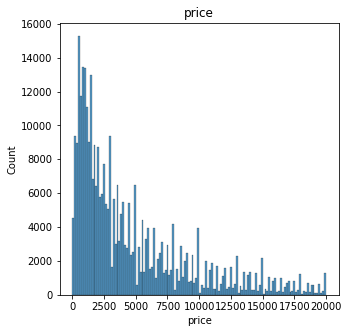

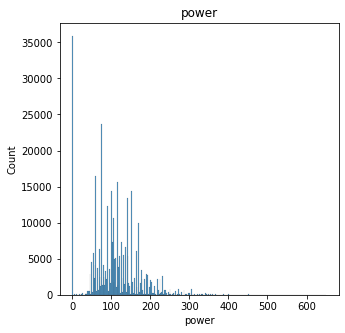

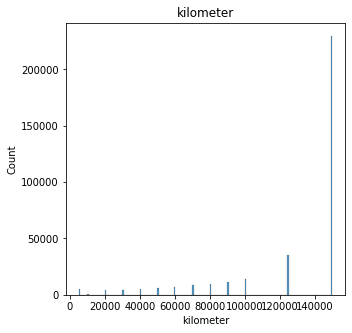

In [30]:
columns =['price', 'power', 'kilometer']
i = 0
for column in columns:
    plt.figure(figsize=(5,5))
    sns.histplot(data=df[column], palette="Blues").set(title=column)
    plt.show()
    i += 1

Построим боксплоты.

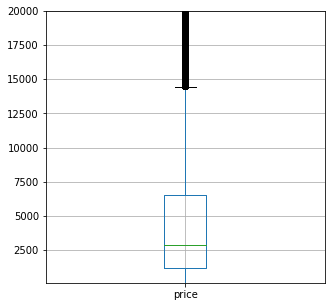

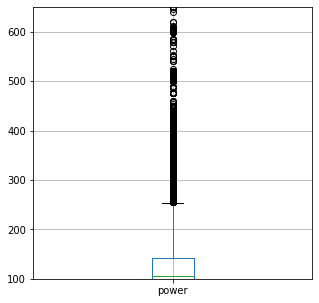

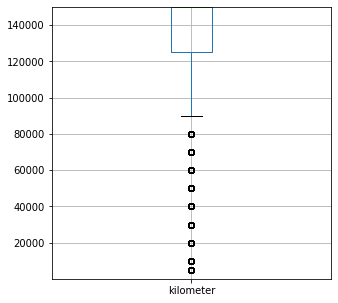

In [31]:
columns =['price', 'power', 'kilometer']
i = 0
for column in columns:
    plt.figure(figsize=(5,5))
    df.boxplot(column)
    plt.ylim(100,df[column].max())
    plt.show()
    i += 1

Достаточно много выбросов даже с нашей корректировкой. Посмотрим, как будут вести себя модели с такой выборкой.

## Обучение моделей

### Модель градиентного бустинга. Библиотекf LightGBM.

Посмотрим на наши признаки.

In [32]:
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

Значения в столбца с датой DateCrawled — дата скачивания анкеты из базы, DateCreated — дата создания анкеты и LastSeen — дата последней активности пользователя вряд ли связаны с ценой авто. В столбце numberofpictures только 0. Удалим эти признаки.

In [33]:
df_LGBD = df.drop(['date_crawled','date_created', 'last_seen','number_of_pictures'], axis=1)
cat = ['vehicle_type','gearbox','model','fuel_type','brand','not_repaired']
for cat_ in cat:
    df_LGBD[cat_] = df_LGBD[cat_].astype('category')
df_LGBD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 342361 entries, 0 to 354368
Data columns (total 12 columns):
 #   Column              Non-Null Count   Dtype   
---  ------              --------------   -----   
 0   price               342361 non-null  int64   
 1   vehicle_type        309098 non-null  category
 2   registration_year   342361 non-null  float64 
 3   gearbox             325397 non-null  category
 4   power               342361 non-null  float64 
 5   model               325104 non-null  category
 6   kilometer           342361 non-null  int64   
 7   registration_month  342361 non-null  int64   
 8   fuel_type           313364 non-null  category
 9   brand               342361 non-null  category
 10  not_repaired        277156 non-null  category
 11  postal_code         342361 non-null  int64   
dtypes: category(6), float64(2), int64(4)
memory usage: 20.6 MB


Разобъем данные на тренировочную и тестовую выборки. И сохраняем их методом Dataset в структуру данных lightgbm. 

In [34]:
features_train, features_valid, target_train, target_valid = train_test_split(
    df_LGBD.drop('price', axis=1), df_LGBD.price, test_size=0.25, random_state=12345)
train_dataset = lgb.Dataset(features_train, target_train, categorical_feature=cat,free_raw_data=False)
valid_dataset = lgb.Dataset(features_valid, target_valid, categorical_feature=cat,free_raw_data=False)

Зададим параметры модели.

1. Random Forest Случайный лес:

In [35]:
params_RF = {'boosting_type' : 'rf',
'metric' : 'rmse',
'learning_rate' : 0.3,
'num_leaves' : 32,
'max_depth' : 6,
'bagging_fraction' : 0.8,
'bagging_freq' : 10,
'feature_fraction' : 0.8,
'lambda_l2' : 0.3,
'lambda_l1' : 0.3}

2. Gradient Boosted Decision Tree Решающее дерево:

In [36]:
params_gbdt = {'boosting_type' : 'gbdt',
'metric' : 'rmse',
'learning_rate' : 0.3,
'num_leaves' : 32,
'max_depth' : 6,
'bagging_fraction' : 0.8,
'bagging_freq' : 10,
'feature_fraction' : 0.8,
'lambda_l2' : 0.3,
'lambda_l1' : 0.3}

2. Gradient-based One-Side Sampling Градиентная односторонняя выборка:

In [37]:
params_goss = {'boosting_type' : 'goss',
'metric' : 'rmse',
'learning_rate' : 0.3,
'num_leaves' : 32,
'max_depth' : 6,
'feature_fraction' : 0.8,
'lambda_l2' : 0.3,
'lambda_l1' : 0.3}

Добавим параметры в отедльный список.

In [38]:
params_ = [params_RF,params_gbdt,params_goss]
RMSE_LB=[]

Напишем для удобстава и компактности функцию.

In [39]:
def LGB(param):
    print(param)
    result = lgb.train(train_set=train_dataset, valid_sets=valid_dataset, params=param,
    num_boost_round=10, early_stopping_rounds=5)
    return result

In [40]:
%%time
print(LGB(params_[0]))

{'boosting_type': 'rf', 'metric': 'rmse', 'learning_rate': 0.3, 'num_leaves': 32, 'max_depth': 6, 'bagging_fraction': 0.8, 'bagging_freq': 10, 'feature_fraction': 0.8, 'lambda_l2': 0.3, 'lambda_l1': 0.3}


/opt/conda/lib/python3.9/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:2065: UserWarning: Using categorical_feature in Dataset.
  _log_warning('Using categorical_feature in Dataset.')


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.385925 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 256770, number of used features: 11
[LightGBM] [Info] Start training from score 4570.612751


/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1780: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/opt/conda/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_column in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[1]	valid_0's rmse: 2497.57
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 2289.02
[3]	valid_0's rmse: 2316.78
[4]	valid_0's rmse: 2276.3
[5]	valid_0's rmse: 2264.96
[6]	valid_0's rmse: 2266.08
[7]	valid_0's rmse: 2268.47
[8]	valid_0's rmse: 2273.01
[9]	valid_0's rmse: 2270.41
[10]	valid_0's rmse: 2270.54
Early stopping, best iteration is:
[5]	valid_0's rmse: 2264.96
Kexibq <lightgbm.basic.Booster object at 0x7f826b3c59a0>
CPU times: user 34.5 s, sys: 298 ms, total: 34.8 s
Wall time: 35.1 s


In [41]:
%%time
LGB(params_[1])

{'boosting_type': 'gbdt', 'metric': 'rmse', 'learning_rate': 0.3, 'num_leaves': 32, 'max_depth': 6, 'bagging_fraction': 0.8, 'bagging_freq': 10, 'feature_fraction': 0.8, 'lambda_l2': 0.3, 'lambda_l1': 0.3}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.397426 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 256770, number of used features: 11
[LightGBM] [Info] Start training from score 4570.612751
[1]	valid_0's rmse: 3632.67
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 3001.3
[3]	valid_0's rmse: 2612.91
[4]	valid_0's rmse: 2328.26
[5]	valid_0's rmse: 2146.12
[6]	valid_0's rmse: 2030.96
[7]	valid_0's rmse: 1958.62
[8]	valid_0's rmse: 1911.67
[9]	valid_0's rmse: 1872.74
[10]	valid_0's rmse: 1848.83
Did not meet early stopping. Best iteratio

In [42]:
%%time
LGB(params_[2])

{'boosting_type': 'goss', 'metric': 'rmse', 'learning_rate': 0.3, 'num_leaves': 32, 'max_depth': 6, 'feature_fraction': 0.8, 'lambda_l2': 0.3, 'lambda_l1': 0.3}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.391121 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 898
[LightGBM] [Info] Number of data points in the train set: 256770, number of used features: 11
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 4570.612751
[1]	valid_0's rmse: 3632.29
Training until validation scores don't improve for 5 rounds
[2]	valid_0's rmse: 2998.9
[3]	valid_0's rmse: 2614
[4]	valid_0's rmse: 2335.21
[5]	valid_0's rmse: 2150.63
[6]	valid_0's rmse: 2039.21
[7]	valid_0's rmse: 1960.84
[8]	valid_0's rmse: 1910.72
[9]	valid_0's rmse: 1871.36
[10]	valid_0's rmse: 1848.86
Did not meet early stopping. Best iteration is:
[10]	valid_0's rmse: 1848.86
CPU times: user 41.6 s, sys: 279 ms, total: 41.9

Значения RMSE с LightGBM ниже 2500. Попробуем запустить обучение без градиентного бустеринга. Категориальные признаки нужно заменить с помощью get_dummies. 

In [43]:
cat = ['vehicle_type','gearbox','model','fuel_type','brand','not_repaired']
category_dummy_df = pd.get_dummies(df[cat], drop_first=True)
df = df.merge(category_dummy_df, left_index=True, right_index=True)
df = df.drop(cat, axis=1)

Не забываем удалить даты и кол-во фотографий.

In [44]:
df = df.drop(['date_crawled','date_created', 'last_seen','number_of_pictures'], axis=1)

In [45]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col])

In [46]:
df

,price,registration_year,power,kilometer,registration_month,postal_code,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,...,brand_skoda,brand_smart,brand_sonstige_autos,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,not_repaired_yes
0,480,1993.0,0.0,150000,0,70435,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,18300,2011.0,190.0,125000,5,66954,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
2,9800,2004.0,163.0,125000,8,90480,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1500,2001.0,75.0,150000,6,91074,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,3600,2008.0,69.0,90000,7,60437,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,2000.0,0.0,150000,3,26624,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
354365,2200,2005.0,0.0,20000,1,39576,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
354366,1199,2000.0,101.0,125000,3,26135,1,0,0,0,...,0,1,0,0,0,0,0,0,0,0
354367,9200,1996.0,102.0,150000,3,87439,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Создаем выборки. Тренировочную и валидационную.

In [47]:
features = df.drop(['price'], axis=1)
target = df['price']
features_train, features_valid, target_train, target_valid = train_test_split(
    features,target,test_size=0.25, random_state=12345)

In [48]:
params_LR = {
             "fit_intercept":[True,False], 
             "normalize":[True,False] 
            }
params_DT = {
              "min_samples_split": [10, 20, 40],
              "max_depth": [2, 6, 8]
              }
params_RF = {
              "n_estimators": [100],
              "max_depth": [2, 6, 8]
            }
params_ = [params_LR,params_DT,params_RF]
models = [LinearRegression(),  DecisionTreeRegressor(), RandomForestRegressor()]
grid_best_estimator_=[]
RMSE=[]

Для того, чтобы вычислить время обучения, запустим обучения разными ячейками(хотя безусловно красивее было бы запустить 1 циклом). Зато напишем функцию для компактности кода.

In [49]:
def modeling(models, params):
    print(models)
    grid = GridSearchCV(models,params,scoring='neg_root_mean_squared_error')
    grid_fit = grid.fit(features_train, target_train)
    grid_best_estimator_.append(grid_fit.best_estimator_)
    y_pred = grid_fit.best_estimator_.predict(features_valid)
    y_pred = pd.DataFrame(y_pred)
    return mean_squared_error(target_valid, y_pred,squared=False)

In [50]:
%%time
RMSE.append(modeling(models[0], params_[0]))
print(RMSE[0])

LinearRegression()
2795.111878909504
CPU times: user 5min 27s, sys: 3min 10s, total: 8min 38s
Wall time: 8min 39s


In [51]:
%%time
RMSE.append(modeling(models[1], params_[1]))
print(RMSE[1])

DecisionTreeRegressor()
2167.5675587885835
CPU times: user 1min 47s, sys: 12.8 s, total: 2min
Wall time: 2min


In [52]:
%%time
RMSE.append(modeling(models[2], params_[2]))
print(RMSE[2])

RandomForestRegressor()
2106.697523163213
CPU times: user 40min 39s, sys: 7.25 s, total: 40min 46s
Wall time: 40min 48s


## Проверка модели на адекватность 

Адекватность модели проверим с помощью DummyRegressor. Посмотрим, какие значения он нам выдаст.

In [53]:
dummy = DummyRegressor(strategy='mean').fit(features_train, target_train)
dummy_pred = dummy.predict(features_valid)
print ('RMSE', mean_squared_error(target_valid, dummy_pred,squared=False))

RMSE 4520.123946456097


Полученное значение RMSE c помощью DummyRegressor выше нашего. Значит, наша работа проделана не даром.

## Анализ моделей

**Выводы по обучению моделей** 
<br>1.По полученным данным RMSE, лучший показательмы получили с помощью дерева решений Gradient Boosting Decision Tree (GBDT) - 1848.83. Wall time: 35,1 s. Похожий резльутат был получен Gradient-based One-Side Sampling Градиентная односторонняя выборка: значение RMSE: 1848.86 со времем работы: Wall time: 42,3 s.
<br>Модель, обученную с помощью дерева решений Gradient Boosting Decision Tree (GBDT) рекомендуем использовать заказчику для определения стоимости авто.
<br>В процессе выполнения проекта были проведены следующие этапы:

1. Подготовка данных
2. Проведен исследовательский анализ данных
3. Построена и обучена модель.